In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [135]:
# Import the necessary libraries
import pandas as pd
import numpy as np

# Run the code again to define and test the Min-Max scaling functions
# Define the function for Min-Max scaling
def min_max_scaling(data):
    """
    Normalize the data using Min-Max scaling.
    Args:
    - data (DataFrame): The data to normalize

    Returns:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column
    """
    scaling_params = {}
    normalized_data = data.copy()

    for column in data.columns:
        min_val = data[column].min()
        max_val = data[column].max()
        scaling_params[column] = {'min': min_val, 'max': max_val}
        normalized_data[column] = (data[column] - min_val) / (max_val - min_val)

    return normalized_data, scaling_params

# Define the function for inverse Min-Max scaling
def inverse_min_max_scaling(normalized_data, scaling_params):
    """
    Reverse the Min-Max scaling to get the original data.
    Args:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column

    Returns:
    - original_data (DataFrame): The data in its original scale
    """
    original_data = normalized_data.copy()

    for idx, column in enumerate(normalized_data.columns):
        # Convert integer column names to string to match with scaling_params keys
        key = str(column) if isinstance(column, int) else column
        keys = list(scaling_params.keys())
        min_val = scaling_params[keys[int(key)]]['min']
        max_val = scaling_params[keys[int(key)]]['max']
        original_data[column] = normalized_data[column] * (max_val - min_val) + min_val

    return original_data

In [136]:
def outlier_handler(data):
    # Convert the 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Extract day of the week and time from the 'date' column
    data['day_of_week'] = data['date'].dt.day_name()
    data['time'] = data['date'].dt.time

    # Define a function to replace outliers with median for each group
    def replace_outliers(group):
        # Iterate over each column in the group
        for col in group.columns:
            if col not in ['date', 'day_of_week', 'time']:
                # Compute the IQR
                Q1 = group[col].quantile(0.25)
                Q3 = group[col].quantile(0.75)
                IQR = Q3 - Q1

                # Define bounds for outliers
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                # Replace outliers with median of the group
                median_val = group[col].median()
                group[col] = group[col].apply(lambda x: median_val if x < lower_bound or x > upper_bound else x)

        return group

    # Group by 'day_of_week' and 'time' and apply the function to replace outliers
    data = data.groupby(['day_of_week', 'time']).apply(replace_outliers)
    data = data.drop(columns=['day_of_week','time'])

    return data

In [137]:
def zero_handler(data, range):
    data['date'] = pd.to_datetime(data['date'])
    data['weekday'] = data['date'].dt.dayofweek
    data['time'] = data['date'].dt.time

    # Loop over each segment column
    for col in data.columns[1:-2]:
        # Group by weekday and time slot
        grouped = data.groupby(['weekday', 'time'])

        # Define a function to apply to each group
        def replace_zeros(group):
            nonzero_mean = group[group != 0].mean()
            if pd.notnull(nonzero_mean):
                return group.replace(0, nonzero_mean)
            else:
                return group

        # Apply the function to each group in the specific segment column
        data[col] = grouped[col].transform(replace_zeros)

    data = data.drop(columns=['weekday','time'])

    return handle_zeros_with_rolling_mean(data, range)

In [138]:
def handle_zeros_with_rolling_mean(data, range):
    for col in data.columns[1:]:
        mv_avg = data[col].rolling(range).mean()
        for i, val in enumerate(data[col]):
            if val == 0:
                data.loc[i,col] = mv_avg[i]
    data = data.tail(-(range))
    return data

In [139]:
def moving_avg_filter(data, window):
    # Calculate the 3-period moving average for each column (excluding the 'date' column)
    for col in data.columns:
        if col != 'date':
            data[col] = data[col].rolling(window).mean()


    # Since the first two rows will have NaN values due to the 3-period moving average,
    # fill them using forward fill.
    data.fillna(method='ffill', inplace=True)

    # Replace any remaining NaN values with zero
    data.fillna(0, inplace=True)

    data = data.tail(-(window-1))

    return data

In [140]:
def formatting_features_targets(data_values, window_size, step_i):
    # Preprocessing and reshaping data
    num_sequences = len(data_values) - window_size
    X = np.array([data_values[i:i+window_size] for i in range(num_sequences)])
    y = np.array([data_values[i+window_size+step_i-1] for i in range(num_sequences)])
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

    return X, y

In [141]:
def get_train_val_test_loaders(X_scaled, y_scaled, val_fraction, test_fraction):
    test_splitter = round(len(X_scaled)*(1-test_fraction))
    X_train_val_scaled , X_test_scaled = X_scaled[:test_splitter] , X_scaled[test_splitter:]
    y_train_val_scaled , y_test_scaled = y_scaled[:test_splitter] , y_scaled[test_splitter:]

    train_val_splitter = round(len(X_train_val_scaled)*(1-val_fraction))
    X_train_scaled , X_val_scaled = X_train_val_scaled[:train_val_splitter] , X_train_val_scaled[train_val_splitter:]
    y_train_scaled , y_val_scaled = y_train_val_scaled[:train_val_splitter] , y_train_val_scaled[train_val_splitter:]


    return X_train_scaled, X_train_val_scaled , X_test_scaled, y_train_scaled, y_train_val_scaled , y_test_scaled,


In [142]:
# Load the dataset
orig_df = pd.read_csv('/content/drive/MyDrive/data/dataset1.csv')

# orig_df = pd.read_csv('/content/drive/MyDrive/data/Initial.csv')


# orig_df = pd.read_csv(f'/content/drive/MyDrive/datasets/avg_run_{minutes}min_dir1.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Semester 5 DSE Project/Data/avg_run_{minutes}min_dir1.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Project Datasets/avg_run_{minutes}min_dir1.csv')

# orig_df = orig_df.drop(columns=['temp','precip','windspeed'])

In [143]:
orig_df.rename(columns={'datetime': 'date'}, inplace=True)


In [145]:
minutes = 5
zero_handle_range = int((15/minutes)*6)
data3 = outlier_handler(orig_df)
data3 = zero_handler(data3, zero_handle_range)
data3 = data3.drop(columns=['date'])

data3, scaling_params2 = min_max_scaling(data3)
data_values3 = data3.values

window_size = int(8/(minutes/60))
step_i = 1
X3, y3 = formatting_features_targets(data_values3, window_size, step_i)

<ipython-input-136-152a4f14454a>:30: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(['day_of_week', 'time']).apply(replace_outliers)


In [146]:
# Get the dimensions
num_samples = X3.shape[0]
sequence_length_x = X3.shape[2]
columns = X3.shape[3]

# Reshape X3
X3_reshaped = X3.reshape((num_samples,sequence_length_x,columns,1,1))

# Reshape y3
future_steps = 1  # From the model architecture
y3_reshaped = y3.reshape((num_samples, future_steps,columns,1))

In [147]:
X_train_scaled, X_train_val_scaled , X_test_scaled, y_train_scaled, y_train_val_scaled , y_test_scaled = get_train_val_test_loaders(X3_reshaped, y3_reshaped, 0.02, 0.02)


In [148]:
X_train_scaled[0]

array([[[[0.11013967]],

        [[0.41056911]],

        [[0.23826789]],

        ...,

        [[0.2716259 ]],

        [[0.17733048]],

        [[0.29818964]]],


       [[[0.08284518]],

        [[0.19233449]],

        [[0.3832562 ]],

        ...,

        [[0.25312089]],

        [[0.21632407]],

        [[0.26587354]]],


       [[[0.09015027]],

        [[0.34320557]],

        [[0.18079656]],

        ...,

        [[0.28484377]],

        [[0.16673292]],

        [[0.31380683]]],


       ...,


       [[[0.06537279]],

        [[0.15360046]],

        [[0.22417498]],

        ...,

        [[0.25506878]],

        [[0.18812429]],

        [[0.30397003]]],


       [[[0.09745537]],

        [[0.23757305]],

        [[0.17611412]],

        ...,

        [[0.2319723 ]],

        [[0.15430872]],

        [[0.29491915]]],


       [[[0.04854063]],

        [[0.13867596]],

        [[0.30164802]],

        ...,

        [[0.29875731]],

        [[0.21801484]],

        [[0.30673

In [149]:
y_train_scaled[0]

array([[[0.12638355],
        [0.67421603],
        [0.16028303],
        [0.35921053],
        [0.24373025],
        [0.25842339],
        [0.09800584],
        [0.4719774 ],
        [0.375     ],
        [0.28374713],
        [0.38138372],
        [0.16408587],
        [0.29968488],
        [0.21088942],
        [0.33084377]]])

In [150]:
sequence_length_x

96

In [151]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.12.0
Running on TPU  ['10.81.220.10:8470']


In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, Dropout, Flatten, RepeatVector, Reshape, \
    TimeDistributed, Dense
from tensorflow.keras.optimizers import RMSprop

with tpu_strategy.scope():
  model = Sequential()
  # model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
  # model.add(LSTM(100, activation='relu'))
  # model.add(BatchNormalization(name='batch_norm_0', input_shape=(sequence_length_x,columns,1,1)))
  # model.add(ConvLSTM2D(name='conv_lstm_1', filters=64, kernel_size=(9, 1), padding='same', return_sequences=True, activation='relu'))
  model.add(ConvLSTM2D(name='conv_lstm_1', filters=64, kernel_size=(9, 1), padding='same', return_sequences=True, activation='relu',input_shape=(sequence_length_x,columns,1,1)))
  # model.add(Dropout(0.5, name='dropout_1'))
  # model.add(BatchNormalization(name='batch_norm_1'))
  model.add(ConvLSTM2D(name='conv_lstm_2', filters=64, kernel_size=(6, 1), padding='same', return_sequences=False, activation='relu'))
  # model.add(Dropout(0.5, name='dropout_2'))
  # model.add(BatchNormalization(name='batch_norm_2'))
  model.add(Flatten())
  model.add(RepeatVector(future_steps))
  model.add(Reshape((future_steps, columns, 1, 64)))
  model.add(ConvLSTM2D(name='conv_lstm_3', filters=64, kernel_size=(9, 1), padding='same', return_sequences=True, activation='relu'))
  # model.add(Dropout(0.5, name='dropout_3'))
  # model.add(BatchNormalization(name='batch_norm_3'))
  model.add(ConvLSTM2D(name='conv_lstm_4', filters=64, kernel_size=(6, 1), padding='same', return_sequences=True, activation='relu'))
  model.add(TimeDistributed(Dense(units=1, name='dense_1', activation='relu')))
  # optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
  model.compile(optimizer = 'adam',loss = "mse")
# fit model
model.fit(X_train_scaled, y_train_scaled, epochs=15,batch_size=64, verbose=1)

Epoch 1/15
561/561 [==============================] - 102s 155ms/step - loss: 0.3267
Epoch 2/15
561/561 [==============================] - 82s 145ms/step - loss: 0.0182
Epoch 3/15
561/561 [==============================] - 82s 146ms/step - loss: 0.0182
Epoch 4/15
561/561 [==============================] - 81s 145ms/step - loss: 0.0182
Epoch 5/15
561/561 [==============================] - 82s 145ms/step - loss: 0.0181
Epoch 6/15
561/561 [==============================] - 82s 145ms/step - loss: 0.0168
Epoch 7/15
561/561 [==============================] - 82s 146ms/step - loss: 0.0089
Epoch 8/15
561/561 [==============================] - 82s 146ms/step - loss: 0.0082
Epoch 9/15
561/561 [==============================] - 82s 145ms/step - loss: 0.0079
Epoch 10/15
561/561 [==============================] - 82s 145ms/step - loss: 0.0077
Epoch 11/15
561/561 [==============================] - 82s 146ms/step - loss: 0.0076
Epoch 12/15
561/561 [==============================] - 82s 146ms/step - l

In [153]:
X_test_scaled.shape

(747, 96, 15, 1, 1)

In [154]:
y_test_scaled.shape

(747, 1, 15, 1)

In [155]:
pred = model.predict(X_test_scaled)

24/24 [==============================] - 4s 107ms/step


In [156]:
pred = pred.reshape((pred.shape[0],pred.shape[2]))

In [157]:
pred[0]

array([0.09047495, 0.18761605, 0.15106425, 0.20389208, 0.12027176,
       0.24817395, 0.08030394, 0.43056232, 0.28435385, 0.23241484,
       0.37107003, 0.16039288, 0.24513015, 0.18847725, 0.27606806],
      dtype=float32)

In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluateModel(model, X_test, y_test, scaling_params=None):
    """
    Evaluate the model and return MSE, RMSE, and MAE.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

    Returns:
    - mse (float): Mean Squared Error
    - rmse (float): Root Mean Squared Error
    - mae (float): Mean Absolute Error
    """

    all_predictions = []
    all_true_values = []

    predictions = model.predict(X_test)
    all_predictions = predictions.reshape((predictions.shape[0],predictions.shape[2]))
    all_true_values = y_test.reshape((y_test.shape[0],y_test.shape[2]))

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    mse = mean_squared_error(all_true_values, all_predictions)
    rmse = mean_squared_error(all_true_values, all_predictions, squared=False)
    mae = mean_absolute_error(all_true_values, all_predictions)

    return mse, rmse, mae

# Dummy code to simulate usage (We don't have the actual model and data here, so this is just for illustration)
# evaluate_model(model, val_loader, device, scaling_params)


In [159]:
mse2, rmse2, mae2 = evaluateModel(model, X_test_scaled,y_test_scaled, scaling_params2)
print(f"MSE: {mse2:.4f}, RMSE: {rmse2:.4f}, MAE: {mae2:.4f}")

24/24 [==============================] - 1s 18ms/step
MSE: 1227.9962, RMSE: 30.6173, MAE: 20.5353


In [160]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Let's update the evaluate_model_per_segment function to compute MSE, RMSE, and MAE for each segment
def evaluate_model_per_segment(model, X_test, y_test, scaling_params=None):
    """
    Evaluate the model for each segment and return metrics.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

    Returns:
    - segment_metrics (dict): Metrics (MSE, RMSE, MAE) for each segment
    """

    all_predictions = []
    all_true_values = []

    # Fetch predictions and true values
    predictions = model.predict(X_test)
    all_predictions = predictions.reshape((predictions.shape[0],predictions.shape[2]))
    all_true_values = y_test.reshape((y_test.shape[0],y_test.shape[2]))

    # Convert to arrays for indexing
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    num_segments = all_predictions.shape[1]
    segment_metrics = {}

    from sklearn.metrics import mean_absolute_error
    overall_mae = mean_absolute_error(all_predictions, all_true_values)
    print(f"Overall Error Metrics ==> MAE : {overall_mae}")

    # Calculate MSE, RMSE, and MAE for each segment
    for segment_idx in range(num_segments):
        segment_predictions = all_predictions[:, segment_idx]
        segment_true_values = all_true_values[:, segment_idx]

        mse = np.mean((segment_predictions - segment_true_values)**2)
        rmse = np.sqrt(mse)
        # mae = np.mean(np.abs(segment_predictions - segment_true_values))
        mae = mean_absolute_error(segment_predictions, segment_true_values)

        segment_metrics[f"Segment {segment_idx+1}"] = {"MSE": mse, "RMSE": rmse, "MAE": mae}

    return segment_metrics

def evaluate_segments(model, X_test, y_test, scaling_params=None):
    segment_metrics = evaluate_model_per_segment(model, X_test, y_test, scaling_params)

    # Display metrics for each segment
    for segment, metrics in segment_metrics.items():
        print(f"{segment} => MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}")


In [161]:
evaluate_segments(model, X_test_scaled,y_test_scaled, scaling_params2)

24/24 [==============================] - 1s 18ms/step
Overall Error Metrics ==> MAE : 20.535269163540693
Segment 1 => MSE: 1143.9758, RMSE: 33.8227, MAE: 18.4260
Segment 2 => MSE: 4833.3110, RMSE: 69.5220, MAE: 51.6414
Segment 3 => MSE: 2997.3258, RMSE: 54.7478, MAE: 41.1435
Segment 4 => MSE: 753.8252, RMSE: 27.4559, MAE: 18.8361
Segment 5 => MSE: 346.3494, RMSE: 18.6105, MAE: 11.5063
Segment 6 => MSE: 1422.4960, RMSE: 37.7160, MAE: 27.7142
Segment 7 => MSE: 342.1059, RMSE: 18.4961, MAE: 9.1277
Segment 8 => MSE: 104.7894, RMSE: 10.2367, MAE: 7.8972
Segment 9 => MSE: 64.5631, RMSE: 8.0351, MAE: 5.8750
Segment 10 => MSE: 508.4730, RMSE: 22.5493, MAE: 15.3210
Segment 11 => MSE: 1633.4960, RMSE: 40.4165, MAE: 28.6032
Segment 12 => MSE: 727.8402, RMSE: 26.9785, MAE: 14.9510
Segment 13 => MSE: 404.9602, RMSE: 20.1236, MAE: 12.8524
Segment 14 => MSE: 298.4541, RMSE: 17.2758, MAE: 11.0011
Segment 15 => MSE: 2837.9773, RMSE: 53.2727, MAE: 33.1328


In [162]:
# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Update the visualize_sorted_predictions function to reverse the normalization
def visualize_sorted_predictions(model, X_test, y_test, scaling_params=None):
    """
    Visualize the sorted predictions and true values in their original scale.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column
    """

    all_predictions = []
    all_true_values = []

    predictions = model.predict(X_test)
    all_predictions = predictions.reshape((predictions.shape[0],predictions.shape[2]))
    all_true_values = y_test.reshape((y_test.shape[0],y_test.shape[2]))

    # Convert to arrays for indexing
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    num_segments = all_predictions.shape[1]
    # print(inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params))

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    # Plotting each segment
    for segment_idx in range(num_segments):
        segment_predictions = all_predictions[:, segment_idx]
        segment_true_values = all_true_values[:, segment_idx]

        # Sorting the actual values and adjusting predictions accordingly
        # sorted_indices = np.argsort(segment_true_values)
        # sorted_true_values = segment_true_values[sorted_indices]
        # sorted_predictions = segment_predictions[sorted_indices]

        # sorted_indices = np.argsort(segment_true_values)
        sorted_true_values = segment_true_values
        sorted_predictions = segment_predictions

        plt.figure(figsize=(12, 6))
        plt.plot(sorted_true_values, label="Actual Values", color='blue')
        plt.plot(sorted_predictions, label="Predicted Values", color='red')
        plt.title(f"Segment {segment_idx+1}")
        plt.xlabel("Sequence Index")
        plt.ylabel("Value")
        plt.legend()
        plt.show()


24/24 [==============================] - 1s 20ms/step


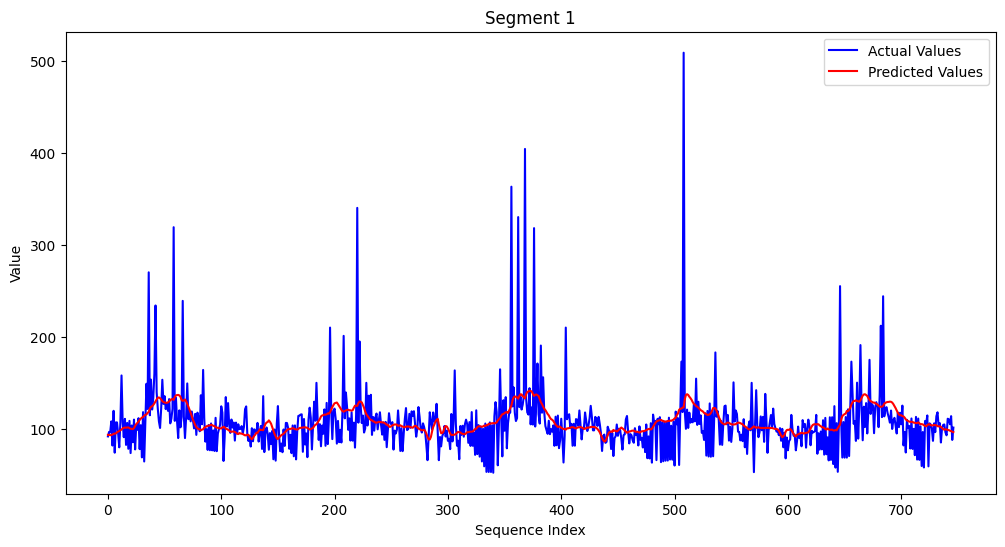

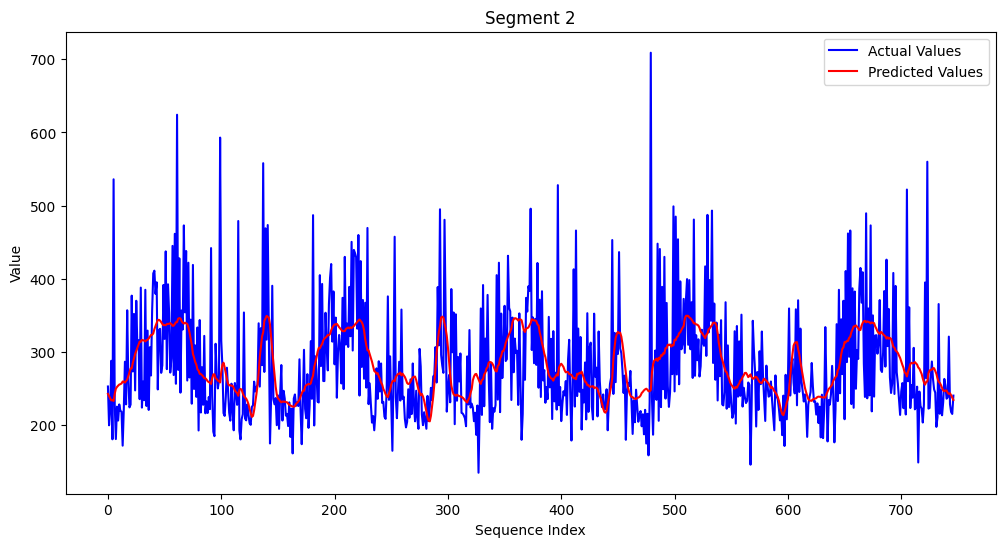

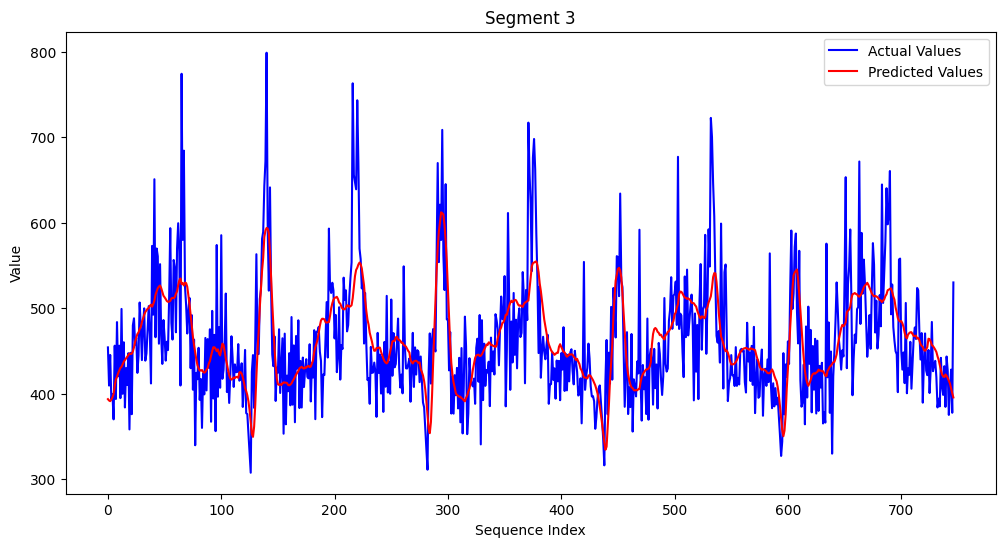

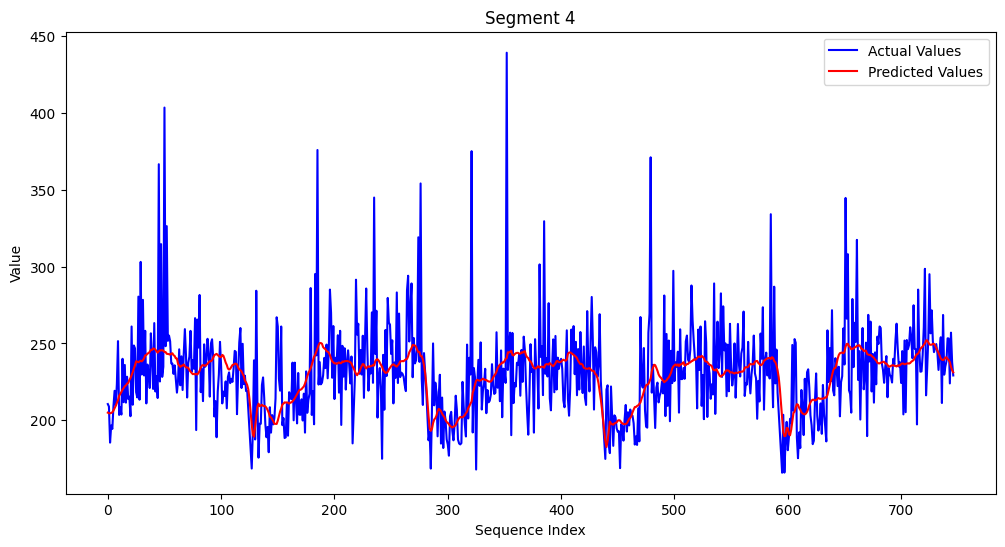

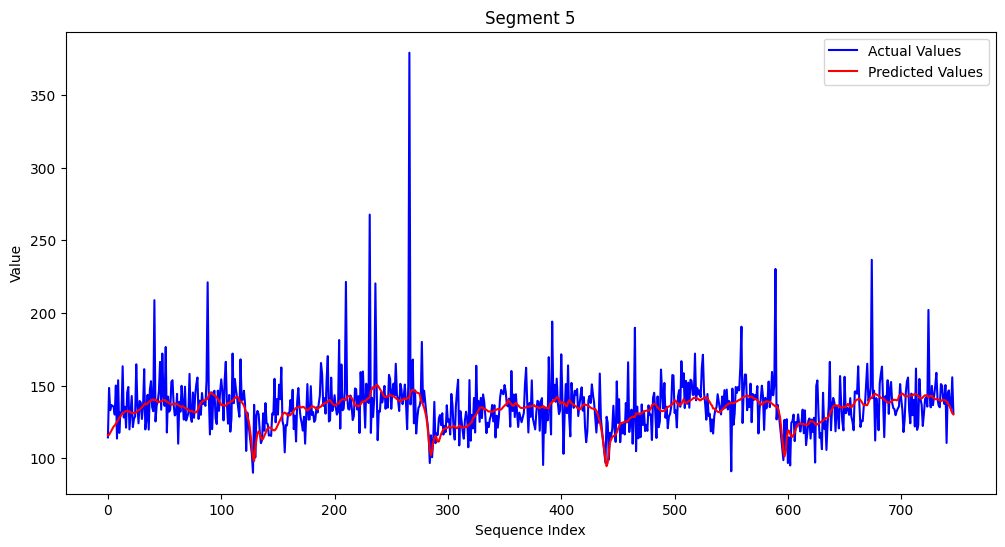

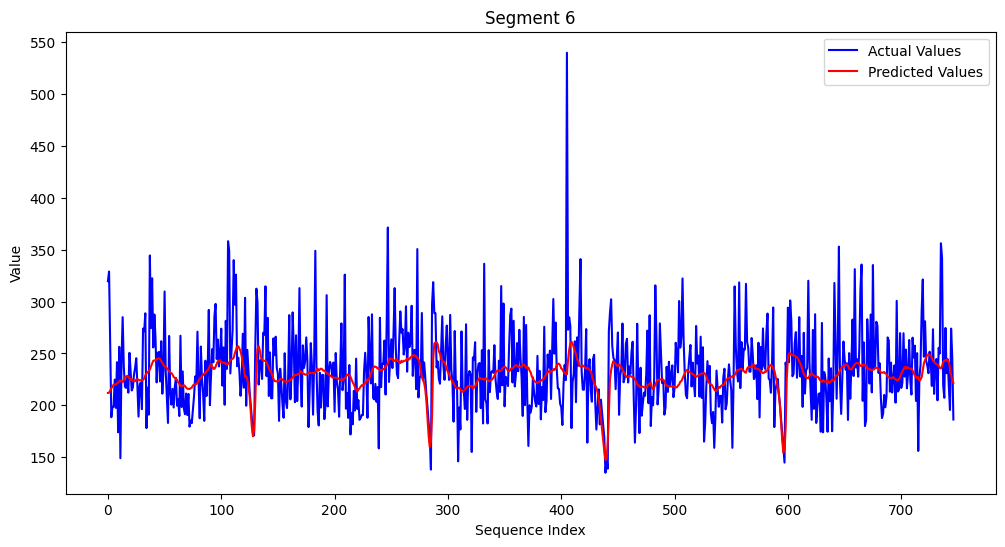

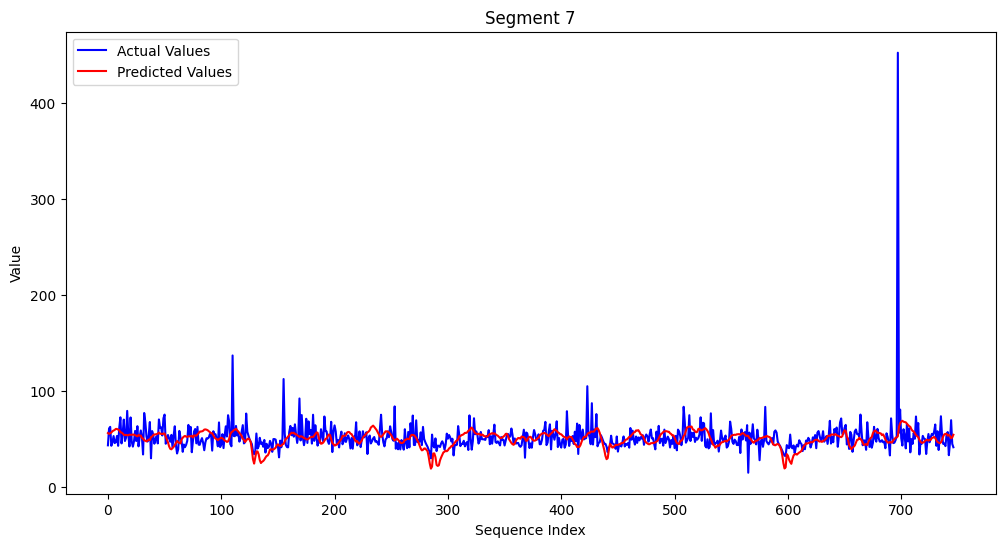

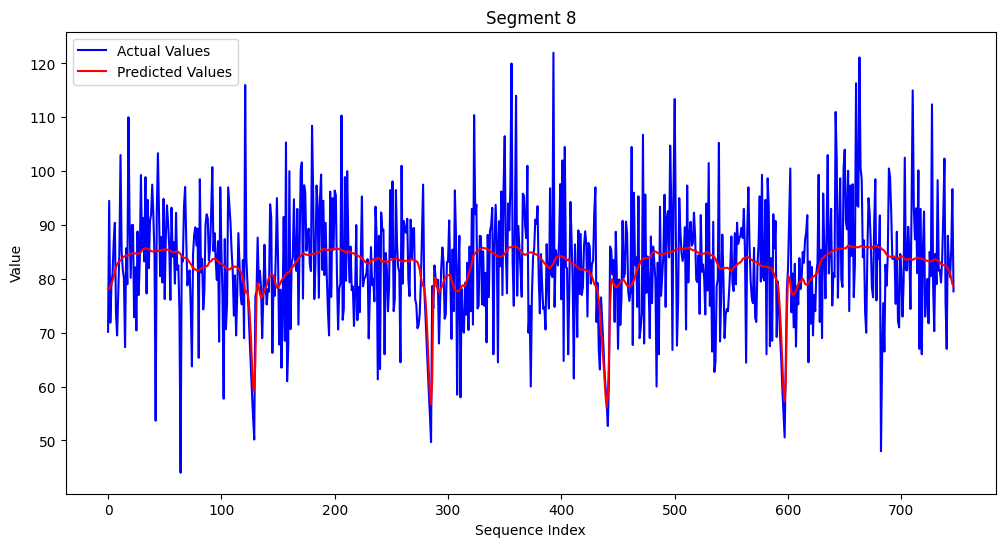

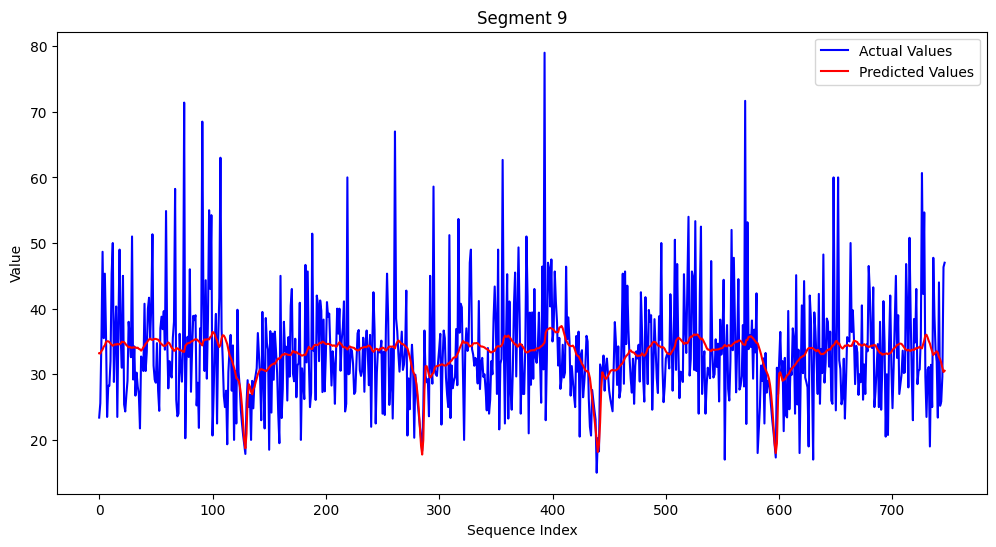

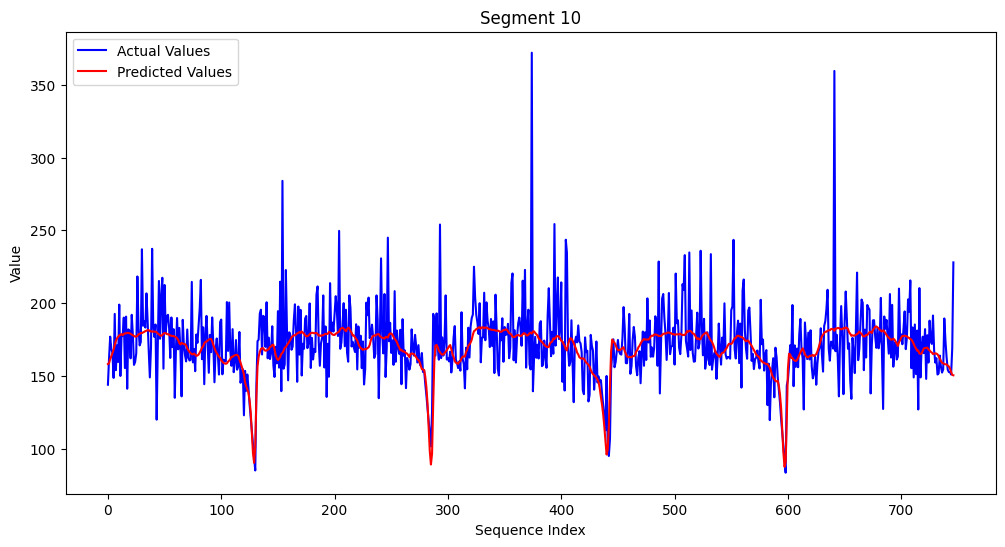

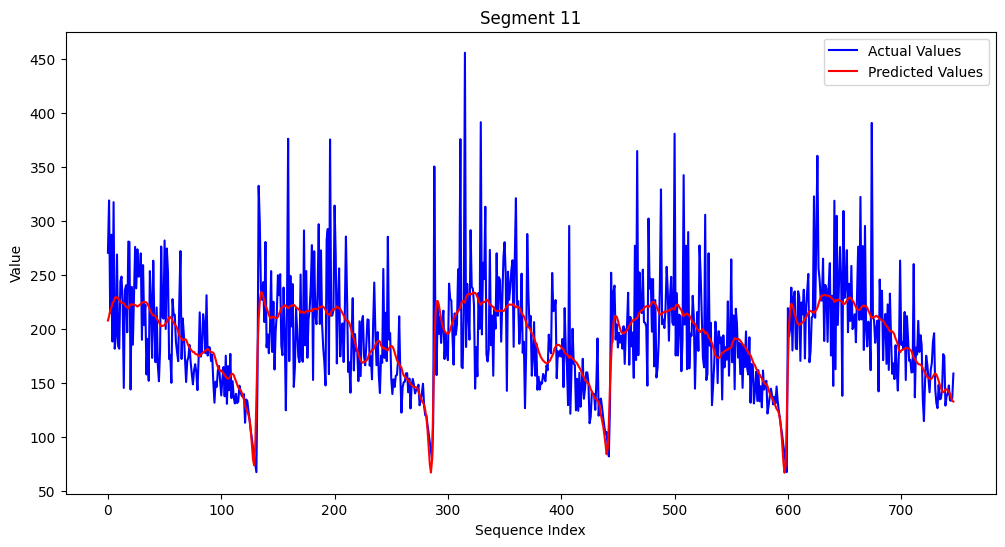

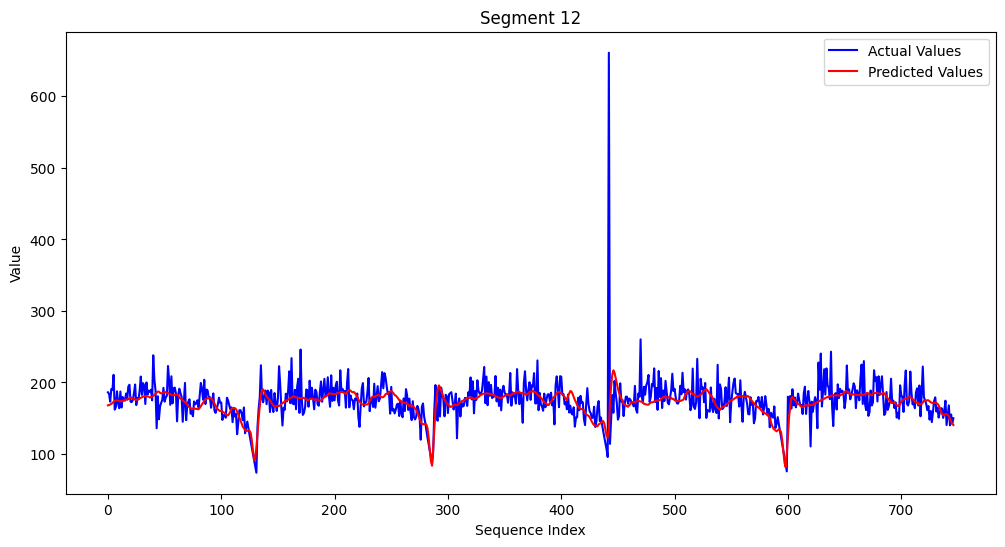

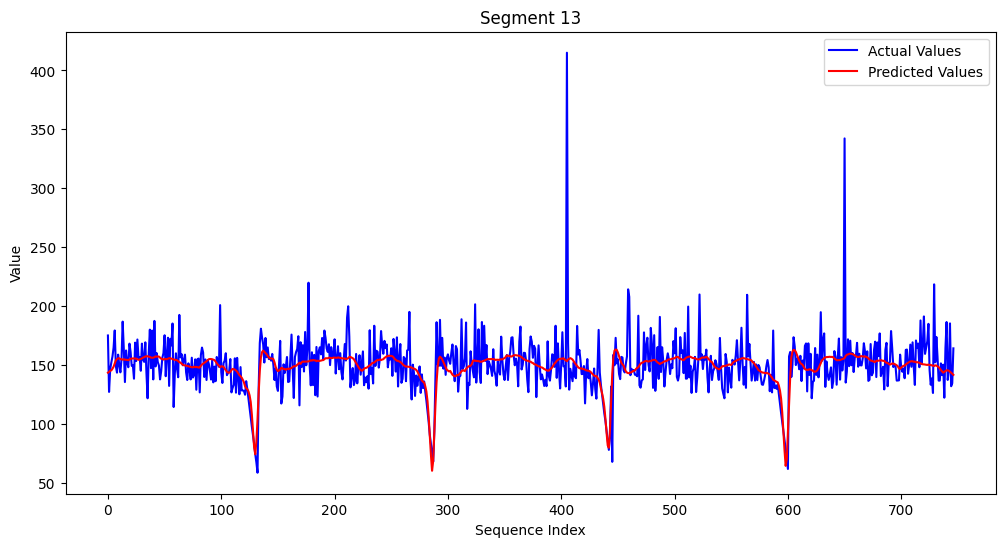

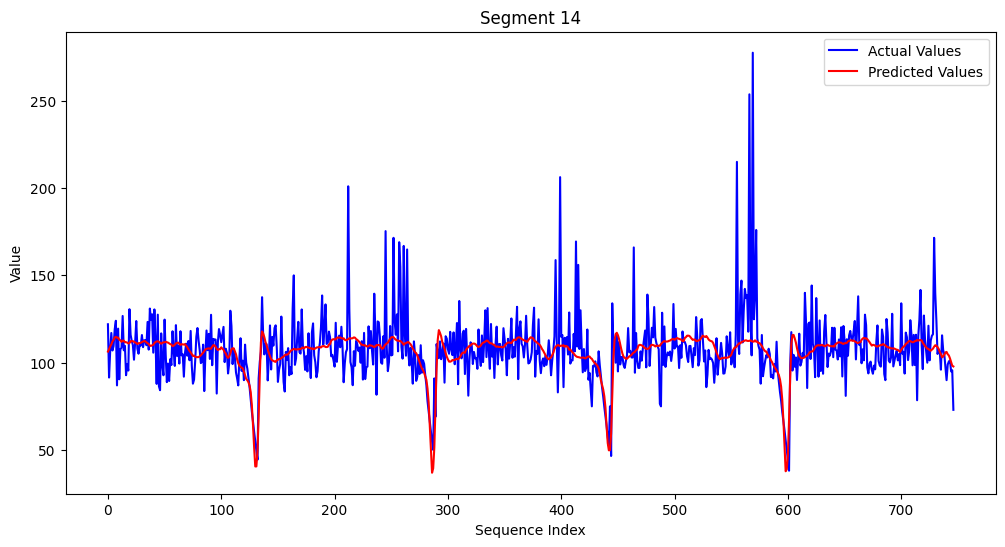

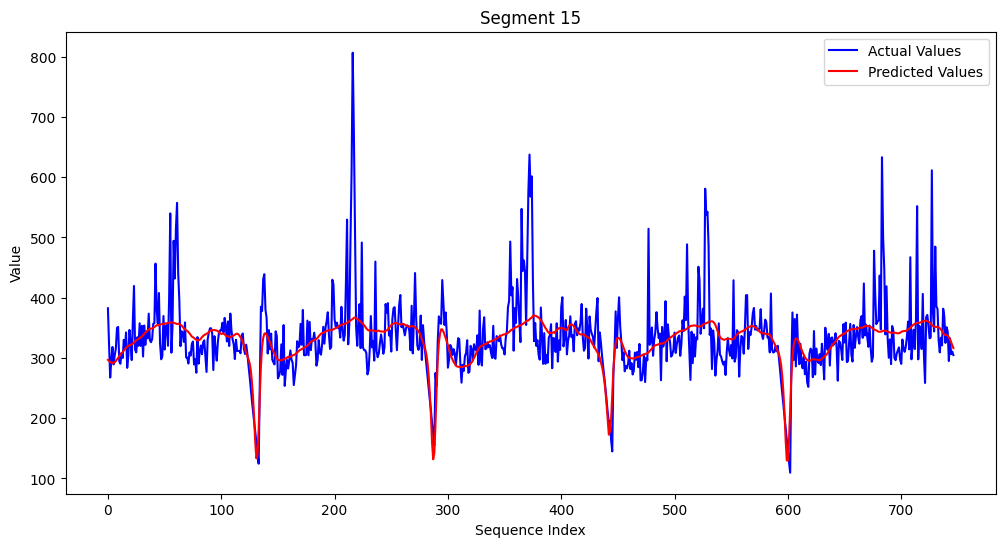

In [163]:
visualize_sorted_predictions(model, X_test_scaled,y_test_scaled, scaling_params2)